# Notebook 2: Data cleaning and structuring, and Logistic Regression

### Libraries used for all notebooks 

In [225]:
# Import libaries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import re
import time
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix

In [226]:
!pip install wordcloud

### Importing CSV files
Previously exported CSV files in Notebook 1 are imported in to perform cleaning

In [227]:
#importing CSV files 
rships = pd.read_csv("../datasets/rships.csv", index_col = 'Unnamed: 0')
jnm = pd.read_csv("../datasets/jnm.csv", index_col = 'Unnamed: 0')

### Setting up the combined dataframes

The dataframes for the separate reddit data were set up so that they can be easily combined. 
Steps:

1. Text columns were renamed to 'posts'

2. Subreddit were numbered 0 for r/relationships and 1 for r/justnomil

In [228]:
#renaming text column to posts
rships.columns = ['posts']
jnm.columns = ['posts']

In [229]:
#creating new columns denoting what subreddit 
rships['subreddit'] = 0
jnm['subreddit'] = 1

### A look at the separate dataframes 

In [230]:
#visual inspection of the data
jnm.head()

,posts,subreddit
0,"Does your MIL suck, but you don't feel like ma...",1
1,MIL has shown her ass to majority of our weddi...,1
2,(TW: Ignorant homophobic tendencies and clearl...,1
3,"Sorry for the typos, trying to post before my ...",1
4,Tw: talk of medical conditions and hospitals\n...,1


In [231]:
rships.head()

,posts,subreddit
0,Tl;dr: New friends at school talking shit abou...,0
1,I was raised by my single mom and I always tho...,0
2,"To begin, my husband and I have been together ...",0
3,"\nI'm very much a hobby baker, I’m still learn...",0
4,I love my girlfriend. We've only been dating f...,0


Text(0.5, 1.0, 'Histogram of distribution of posts from r/justnomil')

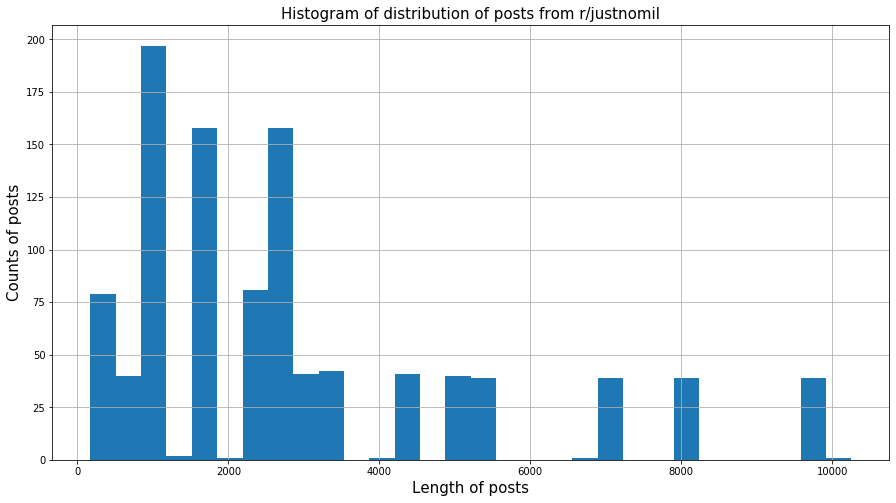

In [232]:
#distribution of length of posts for r/justnomil
plt.figure(figsize = (15,8))
plt.grid()
plt.hist([len(x) for x in jnm['posts']], bins = 30)
plt.ylabel('Counts of posts', size=15)
plt.xlabel('Length of posts', size=15)
plt.title('Histogram of distribution of posts from r/justnomil', size = 15)

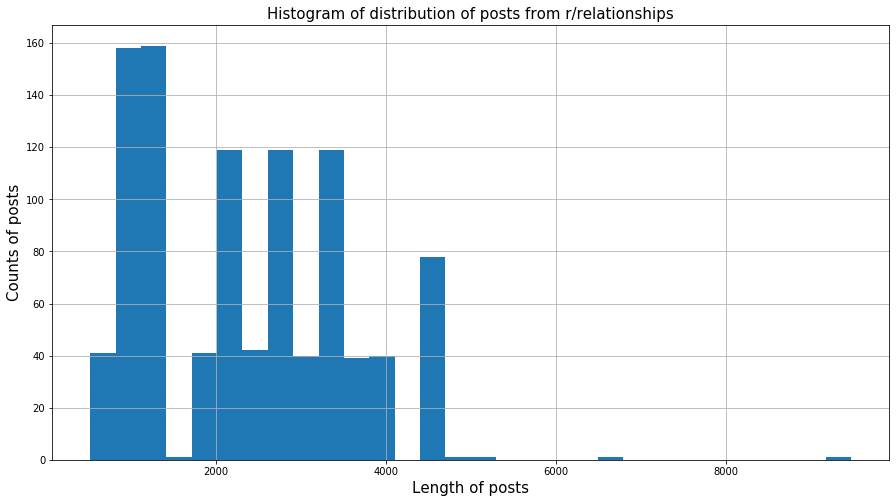

In [233]:
#distribution of posts from r/relationships
plt.figure(figsize = (15,8))
plt.hist([len(x) for x in rships['posts']], bins = 30)
plt.ylabel('Counts of posts', size=15)
plt.xlabel('Length of posts', size=15)
plt.title('Histogram of distribution of posts from r/relationships', size = 15)
plt.grid()

In [234]:
#finding out how many posts were taken from each subreddit
print(len(rships), len(jnm))

1000 1039


In [235]:
#checking if anything were duplicate entries
print(len(rships.duplicated(keep='first'))) #no change in resulting length
print(len(jnm.duplicated(keep='first'))) #no change in resulting length

1000
1039


### Combining the dataframes together

In [236]:
# appending the dataframes together
combined = rships.append(jnm)

In [237]:
#reseting the index to prevent duplicated index numbers
combined = combined.reset_index(drop = True)

In [238]:
combined.tail()

,posts,subreddit
2034,"This weekend was my gf (F, 31) and my (F,24) 5...",1
2035,I just had my third child (second with DH) abo...,1
2036,Old story so no advice wanted for this specifi...,1
2037,I have made this into bullet points so I can c...,1
2038,"I am transgender, female to male, I've been ou...",1


In [239]:
combined.shape

(2039, 2)

### Cleaning of text into clean text without punctuations and stopwords

In [240]:
#importing of stopwords
stopwords = stopwords.words('english')

In [241]:
def clean(text):
    # Function to convert a raw review to a string of words
   
    # 1. Remove HTML.
    new_text = BeautifulSoup(text).get_text()
    
    # 2. Remove non-letters.
    no_links = re.sub("\(https\S+\)", " ", new_text)
    letters_only = re.sub("[^a-zA-Z]", " ", no_links)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Remove 'mil' and 'relationships' as they are in the topic
    topic_words = ['mil', 'relationships']
    new_words = [w for w in words if not w in topic_words]
    
    # 5. Initiate Porterstemmer and stem the text
    p_s = PorterStemmer()
    stemmed = [p_s.stem(x) for x in new_words]
    
    # 6. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords)
    
    # 7. Remove stop words.
    meaningful_words = [w for w in stemmed if not w in stopwords]
    
    # 8. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [242]:
#visual inspection
combined['posts'][981]

"Original post [here](https://old.reddit.com/r/relationships/comments/d9xc55/i_24f_have_a_crush_on_a_guy_29m_at_my_grad_school/).\n\nThanks for all your advice (except for everyone who gave me abuse or told me to just fuck the guy I had a crush on)! I was worried the crush would stay, most people in the comments said it would go away, and I guess you were right.\n\nI talked to my fiancé about it and when we were talking we realized I've been staying at school to study every evening and haven't been making much time for him. I leave school before 6pm now so I get home when he does after he's been to work and we're spending quality time together every day, which is making us closer and helping me remember all the great things that our relationship has.\n\nI also talked to Will (a lot of you suggested that if I got to know him the crush would go away). I didn't tell him about the crush. I just made a friend. We're...very different. It would never work. I basically had 3 conversations with

In [243]:
combined['posts'] = [clean(x) for x in combined['posts']]

In [244]:
#visual inspection of post after cleaning
combined['posts'][981]

'origin post thank advic except everyon gave abus told fuck guy crush wa worri crush would stay peopl comment said would go away guess right talk fianc talk realiz stay school studi everi even make much time leav school befor pm get home doe work spend qualiti time togeth everi day make us closer help rememb great thing relationship ha also talk lot suggest got know crush would go away tell crush made friend veri differ would never work basic convers crush die fun gaze even togeth singl turn engag well go figur feel anymor tl dr chri'

### Wordcloud of frequency of words present in the posts

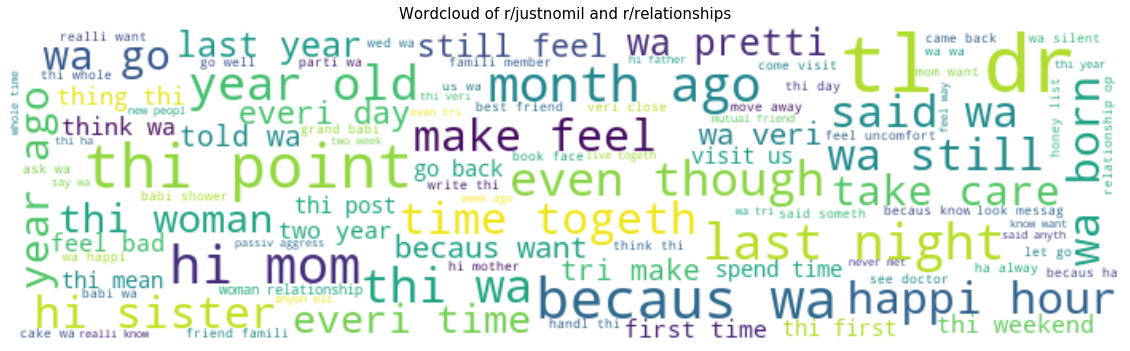

In [245]:
text = " ".join(e for e in combined['posts'])

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", width=700).generate(text)
# Save image file 
wordcloud.to_file("./bag_of_words.png")

# Display the generated image:
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud of r/justnomil and r/relationships', size = 15)
plt.show()

### Analysis of words

The data is split into training and test sets so a model could be created to predict if a post is either from r/relationships or r/justnomil

In [246]:
# making train test split of data
X_train, X_test, y_train, y_test = train_test_split(combined['posts'],
                                                    combined['subreddit'],
                                                    stratify= combined['subreddit'],
                                                    random_state = 42)

In [247]:
#shape of the series
X_train.shape

(1529,)

## Vectorizing

TF-IDF vectorizer was chosen as it penalised more common words and promoted rarer words.

In [248]:
# Pipeline was created
pipe1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
                ])

In [249]:
# the parameters to be tested by the pipeline 
param2 = {'tvec__max_features': [2000, 2500, 3000, 3500],\
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)]}

In [251]:
#gridsearch was initialised and the training set was fitted into it
grid2 = GridSearchCV(pipe1, param_grid=param2, cv = 5, verbose = 1)
grid2.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ongzhongliang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  6.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tvec__max_features': [2000, 2500, 3000, 3500], 'tvec__min_df': [2, 3], 'tvec__max_df': [0.9, 0.95], 'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [252]:
#the parameters that gave the best score
grid2.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [253]:
grid2.best_score_

0.9960758665794637

In [254]:
# using the same parameters, the score was generated for the test datasets
grid2.score(X_test, y_test)

0.9921568627450981

In [255]:
# countvectorizer was initialised with the parameters that was found using gridsearch
tvec = TfidfVectorizer(max_df = 0.9, max_features = 2500, min_df = 2, ngram_range=(1,2))

In [256]:
#X_train data fit graph and the words were vectorised into different columns
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).toarray(),columns = tvec.get_feature_names()) 

In [257]:
#list of words vectorised
tvec_col = tvec.get_feature_names()

In [258]:
print(X_train_tvec.shape)

(1529, 2500)


In [259]:
#X_test words were vectorised into different columns
X_test_tvec = pd.DataFrame(cvec.transform(X_test).toarray(), columns = tvec.get_feature_names()) #transform the X_test data

### Logistic Regression was performed

In [260]:
# logistic regression initialised
lrt = LogisticRegression()

In [261]:
# X_train data fitted
modellrt = lrt.fit(X_train_tvec, y_train)

In [262]:
#score for model was found
scorelrt = lrt.score(X_test_tvec, y_test)

In [263]:
scorelrt

0.7274509803921568

In [278]:
predictionslr = modellrt.predict(X_test_tvec)

In [279]:
confusion_matrix(y_test, predictionslr)

array([[185,  65],
       [ 74, 186]])

In [281]:
tn, fp, fn, tp = confusion_matrix(y_test, predictionslr).ravel()

In [282]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 185
False Positives: 65
False Negatives: 74
True Positives: 186


In [264]:
#words and their coefficients in the logistic regression model were placed into a dataframe
colcoeft = pd.DataFrame()
colcoeft['words'] = [x for x in X_test_tvec.columns]
colcoeft['coeff'] = [y for y in lrt.coef_[0]]

In [265]:
#top 10 words that indicate positive relationship to being a r/justnomil post
colcoeft.sort_values(by = 'coeff', ascending = False).head(10)

,words,coeff
521,dh,3.298945
975,hi,1.807878
150,babi,1.793224
1879,sil,1.709598
2382,wed,1.579031
2441,woman,1.405834
845,go,1.370262
1229,lo,1.313611
2390,weekend,1.222342
731,fil,1.215012


In [266]:
#top 10 words that indicate positive relationship to being a r/relationships post
colcoeft.sort_values(by = 'coeff', ascending = False).tail(10)

,words,coeff
1724,relationship,-1.276915
319,cake,-1.288853
462,crush,-1.342745
1686,raft,-1.386094
1701,realli,-1.424517
1970,stay,-1.442492
2189,tl,-1.516309
2190,tl dr,-1.516309
567,dr,-1.516309
374,class,-1.556452


### Naive Bayes Method

In [267]:
# initialising Multinomial Naive Bayes
nbt = MultinomialNB()

In [268]:
# Fit our model!
modelnbt = nbt.fit(X_train_tvec, y_train)

In [269]:
predictionst = modelnbt.predict(X_test_tvec)

In [270]:
scorenbt_train = modelnbt.score(X_train_tvec, y_train)
scorenbt_train

0.9960758665794637

In [271]:
scorenbt_test = modelnbt.score(X_test_tvec, y_test)
scorenbt_test

0.7235294117647059

In [272]:
confusion_matrix(y_test, predictionst)

array([[220,  30],
       [111, 149]])

In [273]:
tn, fp, fn, tp = confusion_matrix(y_test, predictionst).ravel()

In [274]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 220
False Positives: 30
False Negatives: 111
True Positives: 149


In [275]:
nbtcolcoef = pd.DataFrame()
nbtcolcoef['words'] = [x for x in X_test_tvec.columns]
nbtcolcoef['coeff'] = [y for y in nbt.coef_[0]]

In [276]:
#top 10 words that indicate positive relationship to being a r/justnomil post
nbtcolcoef.sort_values(by = 'coeff', ascending = False).head(10)

,words,coeff
2291,wa,-5.038040
975,hi,-5.362432
521,dh,-5.369427
845,go,-5.512093
179,becaus,-5.546274
2083,thi,-5.588390
916,ha,-5.707384
2356,want,-5.716723
1189,like,-5.758998
1348,mom,-5.972235


In [277]:
#top 10 words that indicate positive relationship to being a r/relationships post
nbtcolcoef.sort_values(by = 'coeff', ascending = False).tail(10)

,words,coeff
1259,love languag,-9.256413
64,amount,-9.256413
1254,lot boyfriend,-9.256413
2039,tact,-9.256413
1,abov,-9.256413
2042,take advantag,-9.256413
65,amount money,-9.256413
2045,take public,-9.256413
1248,look messag,-9.256413
1250,lose sleep,-9.256413
